# Binned plots for the observations climatology
New/updated versions for the paper

In [1]:
import sys
sys.path.append("/home/b/b380887/cold-point-overshoot/python_scripts")
import pickle

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import bin_obs_overshoot as boo

from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [2]:
year_list = [2007, 2008, 2009, 2010]
season_list = ["DJF", "JJA"]
region_dict = {
    "DJF": ["AMZ", "SPC", "IOS", "ECP"],
    "JJA": ["AFR", "WPC", "IOE", "ECP"]
}

years_sorted = list(sorted(year_list))
years_str = str(years_sorted[0]) + "-" + str(years_sorted[-1])
print(years_str)


2007-2010


In [26]:
coords_dict = {
    "ECP": [-150, -100, 0, 15],
    "ECP2": [-150, -100, 0, 15], # repeated
    "WPC": [130, 180, 0, 15],
    "AFR": [-7, 35, 0, 18],
    "IOE": [53, 95, -12, 6],
    "AMZ": [-72, -47, -30, 0],
    "SPC": [165, -145, -20, -5],
    "IOS": [50, 100, -15, 0]
}

#### Get the Tb counts

In [4]:
pickle_dir_hist = "/home/b/b380887/cold-point-overshoot/pickle_files/obs_tb_hists/"
pickle_dir_bin = "/home/b/b380887/cold-point-overshoot/pickle_files/binned_by_tb/climo/new_bins/"


In [5]:
region_tb_counts_dict_djf = {}
qi_means_dict_djf = {}
qi_counts_dict_djf = {}
qi3_means_dict_djf = {}
qi3_counts_dict_djf = {}

region_tb_counts_dict_jja = {}
qi_means_dict_jja = {}
qi_counts_dict_jja = {}
qi3_means_dict_jja = {}
qi3_counts_dict_jja = {}


In [6]:
for region in region_dict["DJF"]:
    with open(pickle_dir_hist + "Tb_histogram_dict_{s}{y}_{r}.pickle".format(r=region, y=years_str, s="DJF"), "rb") as handle:
        tb_count_dict = pickle.load(handle)
    region_tb_counts_dict_djf[region] = tb_count_dict["counts"]

    qi_means_dict_djf[region], qi_counts_dict_djf[region] = boo.load_saved_dicts("qi", "DJF", region, years_str, pickle_dir_bin)
    qi3_means_dict_djf[region], qi3_counts_dict_djf[region] = boo.load_saved_dicts("qi", "DJF", region, years_str, pickle_dir_bin, iflag=3)
    

In [7]:
for region in region_dict["JJA"]:
    with open(pickle_dir_hist + "Tb_histogram_dict_{s}{y}_{r}.pickle".format(r=region, y=years_str, s="JJA"), "rb") as handle:
        tb_count_dict = pickle.load(handle)
    region_tb_counts_dict_jja[region] = tb_count_dict["counts"]

    qi_means_dict_jja[region], qi_counts_dict_jja[region] = boo.load_saved_dicts("qi", "JJA", region, years_str, pickle_dir_bin)
    qi3_means_dict_jja[region], qi3_counts_dict_jja[region] = boo.load_saved_dicts("qi", "JJA", region, years_str, pickle_dir_bin, iflag=3)
    

#### Make the plots

#### All retrievals

In [8]:
def map_subplot(axis, coords, projection, labsize, hide_lats=False, panel_width=100,
                panel_height=60, xrot=0, lw=8, dx=20, dy=15, lat_min=-30, tick_len=14):
    """ Code to plot a map of one region on an axis
    """
    # change to (0 --> 360) if it crosses the dateline
    if coords[1] < coords[0]:
        lon_min = coords[0] % 360
        lon_max = coords[1] % 360
    else:
        lon_min = coords[0]
        lon_max = coords[1]

    rect_width = lon_max - lon_min
    rect_height = coords[3] - coords[2]
    xdiff = (panel_width - rect_width)/2
    
    bottom = lat_min
    top = lat_min + panel_height
    left = 5*round((lon_min - xdiff)/5)
    right = 5*round((lon_max + xdiff)/5)
    extent = [left, right, bottom, top]

    axis.add_feature(cfeature.COASTLINE, linewidth=2)
    axis.stock_img() # this works, but not stamen terrain

    # gridlines and axis labels
    ylocs = np.arange(bottom, top+1, dy) 
    if right > 180:
        left_180 = (left + 180) % 360 - 180
        right_180 = (right + 180) % 360 - 180
        pos_locs = np.arange(left_180, 180, dx)
        neg_left = (pos_locs[-1] + dx) - 360
        neg_locs = np.arange(neg_left, right_180+1, dx)
        xlocs = [
            *pos_locs,
            *neg_locs
        ]
    else:
        xlocs = np.arange(left, right+1, dx)
    gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        xlocs=xlocs, ylocs=ylocs, 
                        linewidth=2, color='k', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': labsize, 'rotation': xrot}
    gl.ylabel_style = {'size': labsize}


    # add region borders
    axis.add_patch(mpatches.Rectangle(xy=[coords[0], coords[2]], 
                              width=rect_width,
                              height=rect_height,
                              fill=False, color='k', linewidth=lw,
                              transform=ccrs.PlateCarree(), zorder=10
                             ))

    axis.set_extent(extent, crs=ccrs.PlateCarree(central_longitude=0))


In [27]:
def bin_qi_season(means_dict, counts_dict, region_tb_counts_dict, season, years_str, bins,  mean_lims=(1e-6, 5e-4),
                  coords_dict=coords_dict, fsize=26, tsize=30, labsize=24, figsize=(33, 18), tb_count_lims=(1, 1000),
                   count_cmap="Spectral", mean_cmap="PiYG", save=False, save_dir=None, show_maps=True, si=False): 
    """
    Plot DARDAR qi values binned by MERGIR brightness temperatures at levels relative to the cold 
    point. Variable "statistic" is "count" or "mean". Plots the Tb bin count at the bottom instead of
    the -1000m level.
    """
    regions = list(region_tb_counts_dict.keys())
    long_name = "cloud ice"
    units = "kg/kg"
    
    ind_offsets = [-2, -1, 0, 1, 2]  
#     offset_labs = [
#         "T$_b$ bin counts",
#         "~500 m below",
#         "At cold point",
#         "~500 m above",
#         "~1000 m above"
#     ]
    offset_labs = [
        "T$_b$ bin counts",
        "-500 m",
        "Cold point",
        "+500 m",
        "+1000 m"
    ]
    
    
    # set up figure
    fig = plt.figure(figsize=figsize)
    if show_maps:
        gs = GridSpec(5, 21, figure=fig, height_ratios=[0.25, 3, 4, 5, 0.75], hspace=0.7, wspace=0.5)
        projection = ccrs.PlateCarree(central_longitude=180)
    else:
        gs = GridSpec(4, 21, figure=fig, height_ratios=[0.25, 4, 5, 0.75], hspace=0.7, wspace=0.5)

    if len(season) == 2:
        ax_title_left = fig.add_subplot(gs[0, :10])
        ax_title_right = fig.add_subplot(gs[0, 10:20])
    else:
        ax_title = fig.add_subplot(gs[0, :20])
        
    if show_maps:
        # different projection for land (center on 0, not 180)
        if regions[0] == "AFR" or regions[0] == "AMZ":
            proj_0 = ccrs.PlateCarree(central_longitude=0)
        else:
            proj_0 = ccrs.PlateCarree(central_longitude=180)
        if regions[2] == "AFR" or regions[2] == "AMZ":
            proj_2 = ccrs.PlateCarree(central_longitude=0)
        else:
            proj_2 = ccrs.PlateCarree(central_longitude=180)
        map_axes = [
            fig.add_subplot(gs[1, :5], projection=proj_0),
            fig.add_subplot(gs[1, 5:10], projection=projection),
            fig.add_subplot(gs[1, 10:15], projection=proj_2),
            fig.add_subplot(gs[1, 15:20], projection=projection),
        ]
        mean_axes = [
            fig.add_subplot(gs[2, :5]),
            fig.add_subplot(gs[2, 5:10]),
            fig.add_subplot(gs[2, 10:15]),
            fig.add_subplot(gs[2, 15:20]),
        ]
        count_axes = [
            fig.add_subplot(gs[3, :5]),
            fig.add_subplot(gs[3, 5:10]),
            fig.add_subplot(gs[3, 10:15]),
            fig.add_subplot(gs[3, 15:20]),
        ]
        cbar_axes = [
            fig.add_subplot(gs[4, 2:9]),
            fig.add_subplot(gs[4, 12:19]),
        ]
    else:
        mean_axes = [
            fig.add_subplot(gs[1, :5]),
            fig.add_subplot(gs[1, 5:10]),
            fig.add_subplot(gs[1, 10:15]),
            fig.add_subplot(gs[1, 15:20]),
        ]
        count_axes = [
            fig.add_subplot(gs[2, :5]),
            fig.add_subplot(gs[2, 5:10]),
            fig.add_subplot(gs[2, 10:15]),
            fig.add_subplot(gs[2, 15:20]),
        ]
        cbar_axes = [
            fig.add_subplot(gs[3, 2:9]),
            fig.add_subplot(gs[3, 12:19]),
        ]
        
    # plot 
    bin_mean_values = (bins[:-1] + bins[1:])/2
    for i, region in enumerate(regions):
        bin_mean_dict = means_dict[region]
        bin_count_dict = counts_dict[region]
        tb_counts = region_tb_counts_dict[region]
        if show_maps:
            ax_map = map_axes[i]
        ax_mean = mean_axes[i]
        ax_count = count_axes[i]

        # turn the values into arrays
        bin_mean_dict_arr = np.array(list(bin_mean_dict.values()))[1:, :]
        bin_count_dict_arr = np.array(list(bin_count_dict.values()))[1:, :]
        tiled_counts = np.zeros((len(ind_offsets), len(tb_counts)))
        tiled_counts[0, :] = tb_counts
        tiled_counts[1:, :] = np.nan
        
        # plot map
        if show_maps:
            if region == "ECP2":
                region_txt = "ECP"
            else:
                region_txt = region
            ax_map.set_title(region_txt, fontsize=tsize)
            if i == 0:
                map_subplot(ax_map, coords_dict[region], proj_0, labsize=fsize, xrot=20, panel_width=125, dy=15, dx=25)
            elif i == 2:
                map_subplot(ax_map, coords_dict[region], proj_2, labsize=fsize, xrot=20, panel_width=125, dy=15, dx=25)
            else:
                map_subplot(ax_map, coords_dict[region], projection, labsize=fsize, xrot=20, panel_width=125, dy=15, dx=25)

        # plot bin means
        pcm1 = ax_mean.pcolormesh(bin_mean_values, ind_offsets[1:], bin_mean_dict_arr, cmap=mean_cmap,
                             norm=mcolors.LogNorm(vmin=mean_lims[0], vmax=mean_lims[1]))
        # pcm2 = ax_mean.pcolormesh(bin_mean_values, ind_offsets, tiled_counts,
        #               cmap=count_cmap, norm=mcolors.LogNorm(vmin=tb_count_lims[0], vmax=tb_count_lims[1])
        #             )
        
        # plot bin counts
        pcm_c1 = ax_count.pcolormesh(bin_mean_values, ind_offsets[1:], bin_count_dict_arr, cmap=count_cmap,
                             norm=mcolors.LogNorm(vmin=tb_count_lims[0], vmax=tb_count_lims[1]))
        pcm_c2 = ax_count.pcolormesh(bin_mean_values, ind_offsets, tiled_counts,
                      cmap=count_cmap, norm=mcolors.LogNorm(vmin=tb_count_lims[0], vmax=tb_count_lims[1])
                    )
        
        # format axes (all)
        for ax in [ax_mean, ax_count]:
            ax.tick_params(axis="y", labelsize=fsize+2, length=0)
            ax.set_xticks(bins[::4])        
            ax.tick_params(axis="x", rotation=45, labelsize=labsize)
            ax.tick_params(axis="y", labelsize=labsize)
            ax.xaxis.set_minor_locator(mticker.MultipleLocator(2))
            ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
            ax.tick_params(which='minor', length=10)
            ax.tick_params(which='major', length=14)
        
        # titles for clarity
        ax_mean.set_title("Bin-mean cloud ice", fontsize=fsize)
        ax_count.set_title("Bin counts", fontsize=fsize)

        # add horizontal borders
        for ind in ind_offsets[:-1]:
            gap = 0.5
            ax_mean.axhline(ind+0.5, color="k", linewidth=2)
            if ind == -2:
                ax_count.axhline(ind+0.5, color="k", linewidth=8)
            else:
                ax_count.axhline(ind+0.5, color="k", linewidth=2)
                
        # only y tick labels on left subplots
        if i == 0:
            ax_mean.set_yticks(ind_offsets[1:])
            ax_mean.set_yticklabels(offset_labs[1:], fontsize=fsize+2)
            ax_count.set_yticks(ind_offsets)
            ax_count.set_yticklabels(offset_labs, fontsize=fsize)
        else:
            ax_count.set_yticks(ind_offsets)
            ax_count.set_yticklabels([""]*len(ind_offsets))
            # ax_mean.set_yticks(ind_offsets)
            # ax_mean.set_yticklabels([""]*len(ind_offsets))
            ax_mean.set_yticks(ind_offsets[1:])
            ax_mean.set_yticklabels([""]*(len(ind_offsets)-1))

        # only x axis labels on bottom subplots
        ax_count.set_xlabel("Brightness temperature (K)", fontsize=fsize)
        
    # bin mean colorbar
    axins1 = inset_axes(cbar_axes[0], width="100%", height="80%", loc='center')
    cbar_axes[0].axis("off")
    cb1 = plt.colorbar(pcm1, cax=axins1, extend="max", orientation="horizontal")
    cb1.ax.tick_params(labelsize=fsize)
    cb1.set_label("Bin-mean {n} ({u})".format(n=long_name, u=units), fontsize=fsize+5)
    cb1.ax.tick_params(which='minor', length=10)
    cb1.ax.tick_params(which='major', length=14)     
    
    # count colorbar
    axins2 = inset_axes(cbar_axes[1], width="100%", height="80%", loc='center')
    cbar_axes[1].axis("off")
    cb2 = plt.colorbar(pcm_c2, cax=axins2, extend="max", orientation="horizontal")
    cb2.ax.tick_params(labelsize=fsize)
    cb2.set_label("Bin counts", fontsize=fsize+5)
    cb2.ax.tick_params(which='minor', length=10)
    cb2.ax.tick_params(which='major', length=14) 
    
    # title
    if len(season) == 2:
        ax_title_left.axis("off")
        ax_title_left.text(x=0.5, y=0, s="{s} {y}".format(s=season[0], y=years_str.replace("-", "—")), verticalalignment="center",
                      horizontalalignment="center", fontsize=tsize+5
                      )
        ax_title_right.axis("off")
        ax_title_right.text(x=0.5, y=0, s="{s} {y}".format(s=season[1], y=years_str.replace("-", "—")), verticalalignment="center",
                      horizontalalignment="center", fontsize=tsize+5
                      )
    else:
        ax_title.axis("off")
        ax_title.text(x=0.5, y=0, s="{s} {y}".format(s=season, y=years_str.replace("-", "—")), verticalalignment="center",
                      horizontalalignment="center", fontsize=tsize+5
                      )

    if save:
        if save_dir is None:
            raise Exception("Must provide save_dir if you want to save the plot")
            
        if show_maps:
            extr = "_and_map"
        else:
            extr = ""
            
        if len(season) == 2:
            type_str = "both_instr_"
        else:
            type_str = season
        
        if si:
            si_str = "_si"
        else:
            si_str = ""
            
        print("DARDAR_qi_binned_by_Tb_with_counts{e}_{t}{y}{s}.png".format(e=extr, t=type_str, y=years_str, s=si_str))
        plt.savefig(save_dir + "DARDAR_qi_binned_by_Tb_with_counts{e}_{t}{y}{s}.png".format(e=extr, t=type_str, y=years_str, s=si_str),
                    dpi=300, bbox_inches="tight"
                   )

    plt.show()
    

In [20]:
save_plots = True 
plot_save_dir = "/home/b/b380887/cold-point-overshoot/plots/obs_paper/climo/new_bins/"

tb_bins = np.arange(186, 301, 2)
qi_lims = (1e-6, 1e-3)
count_lims=(1, 1e5)
figsize = (60, 33)

fsize = 35
tsize = 60
labsize = 30

count_cmap = "viridis"
mean_cmap = "PuBuGn"


DARDAR_qi_binned_by_Tb_with_counts_and_map_DJF2007-2010.png


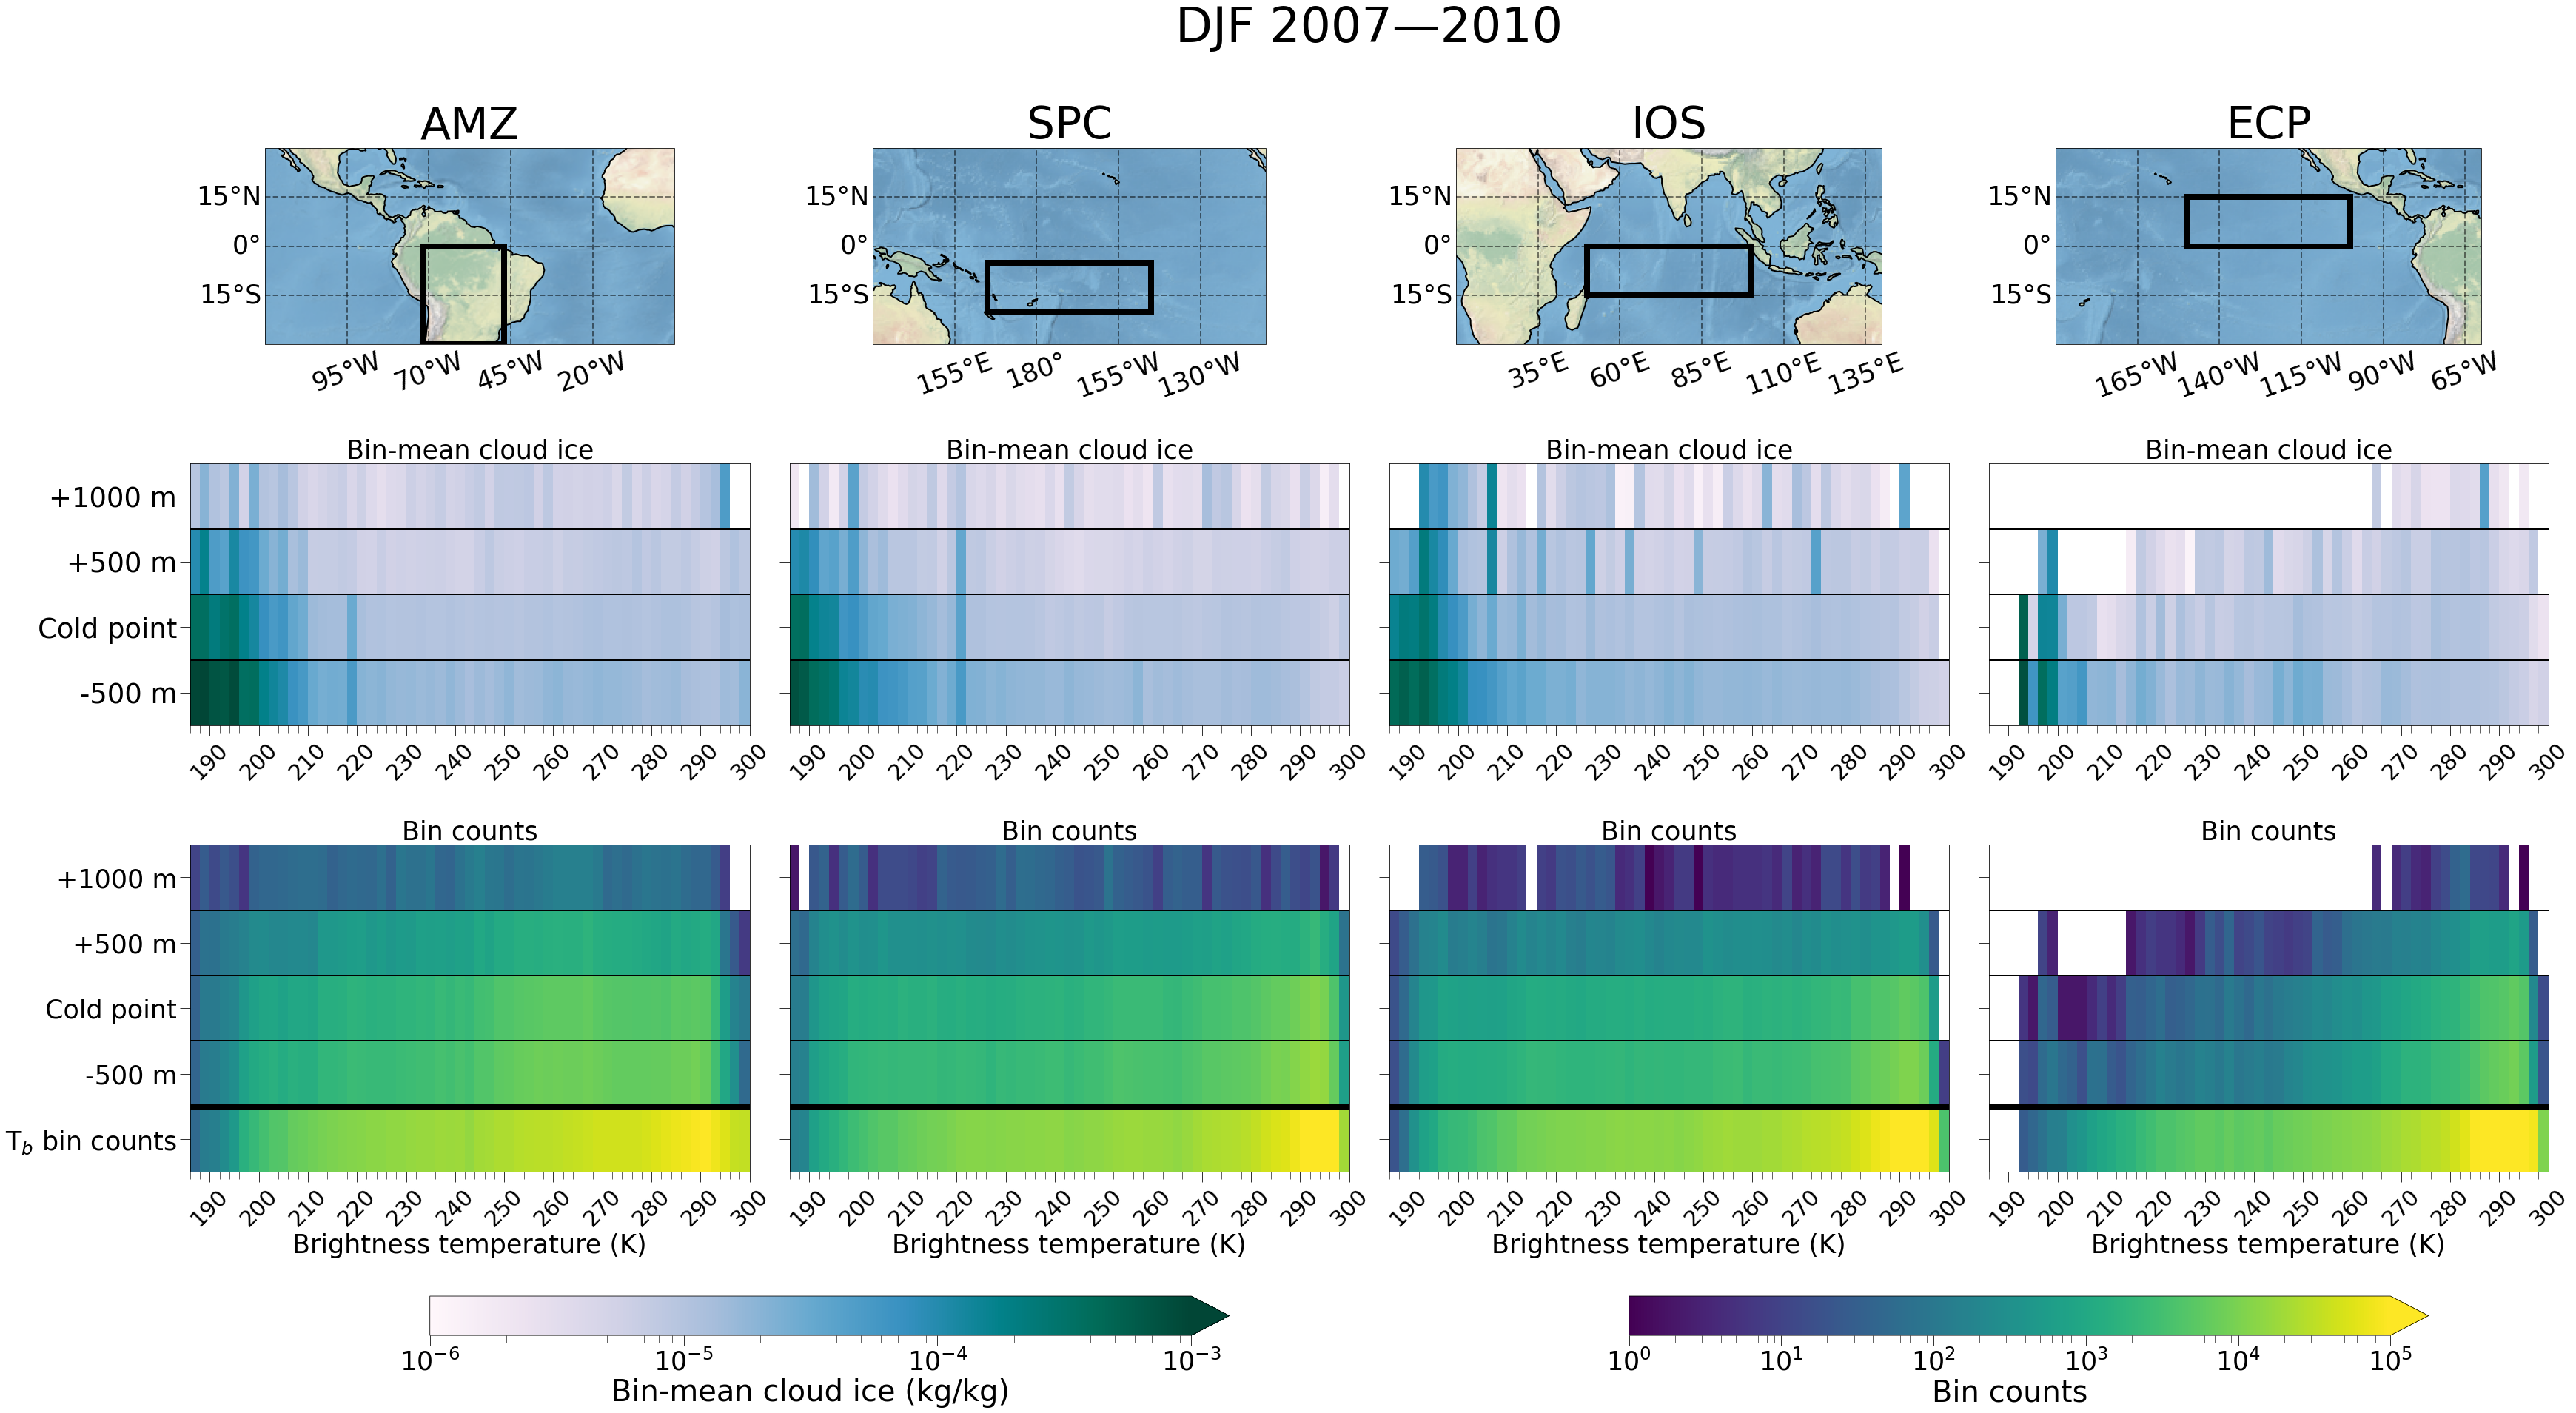

In [21]:
# DJF
bin_qi_season(qi_means_dict_djf, qi_counts_dict_djf, region_tb_counts_dict_djf, "DJF", years_str, tb_bins, mean_lims=qi_lims,
                   fsize=fsize, tsize=tsize, labsize=30, figsize=figsize, tb_count_lims=count_lims,
                   count_cmap=count_cmap, mean_cmap=mean_cmap, save=save_plots, save_dir=plot_save_dir)


DARDAR_qi_binned_by_Tb_with_counts_and_map_JJA2007-2010.png


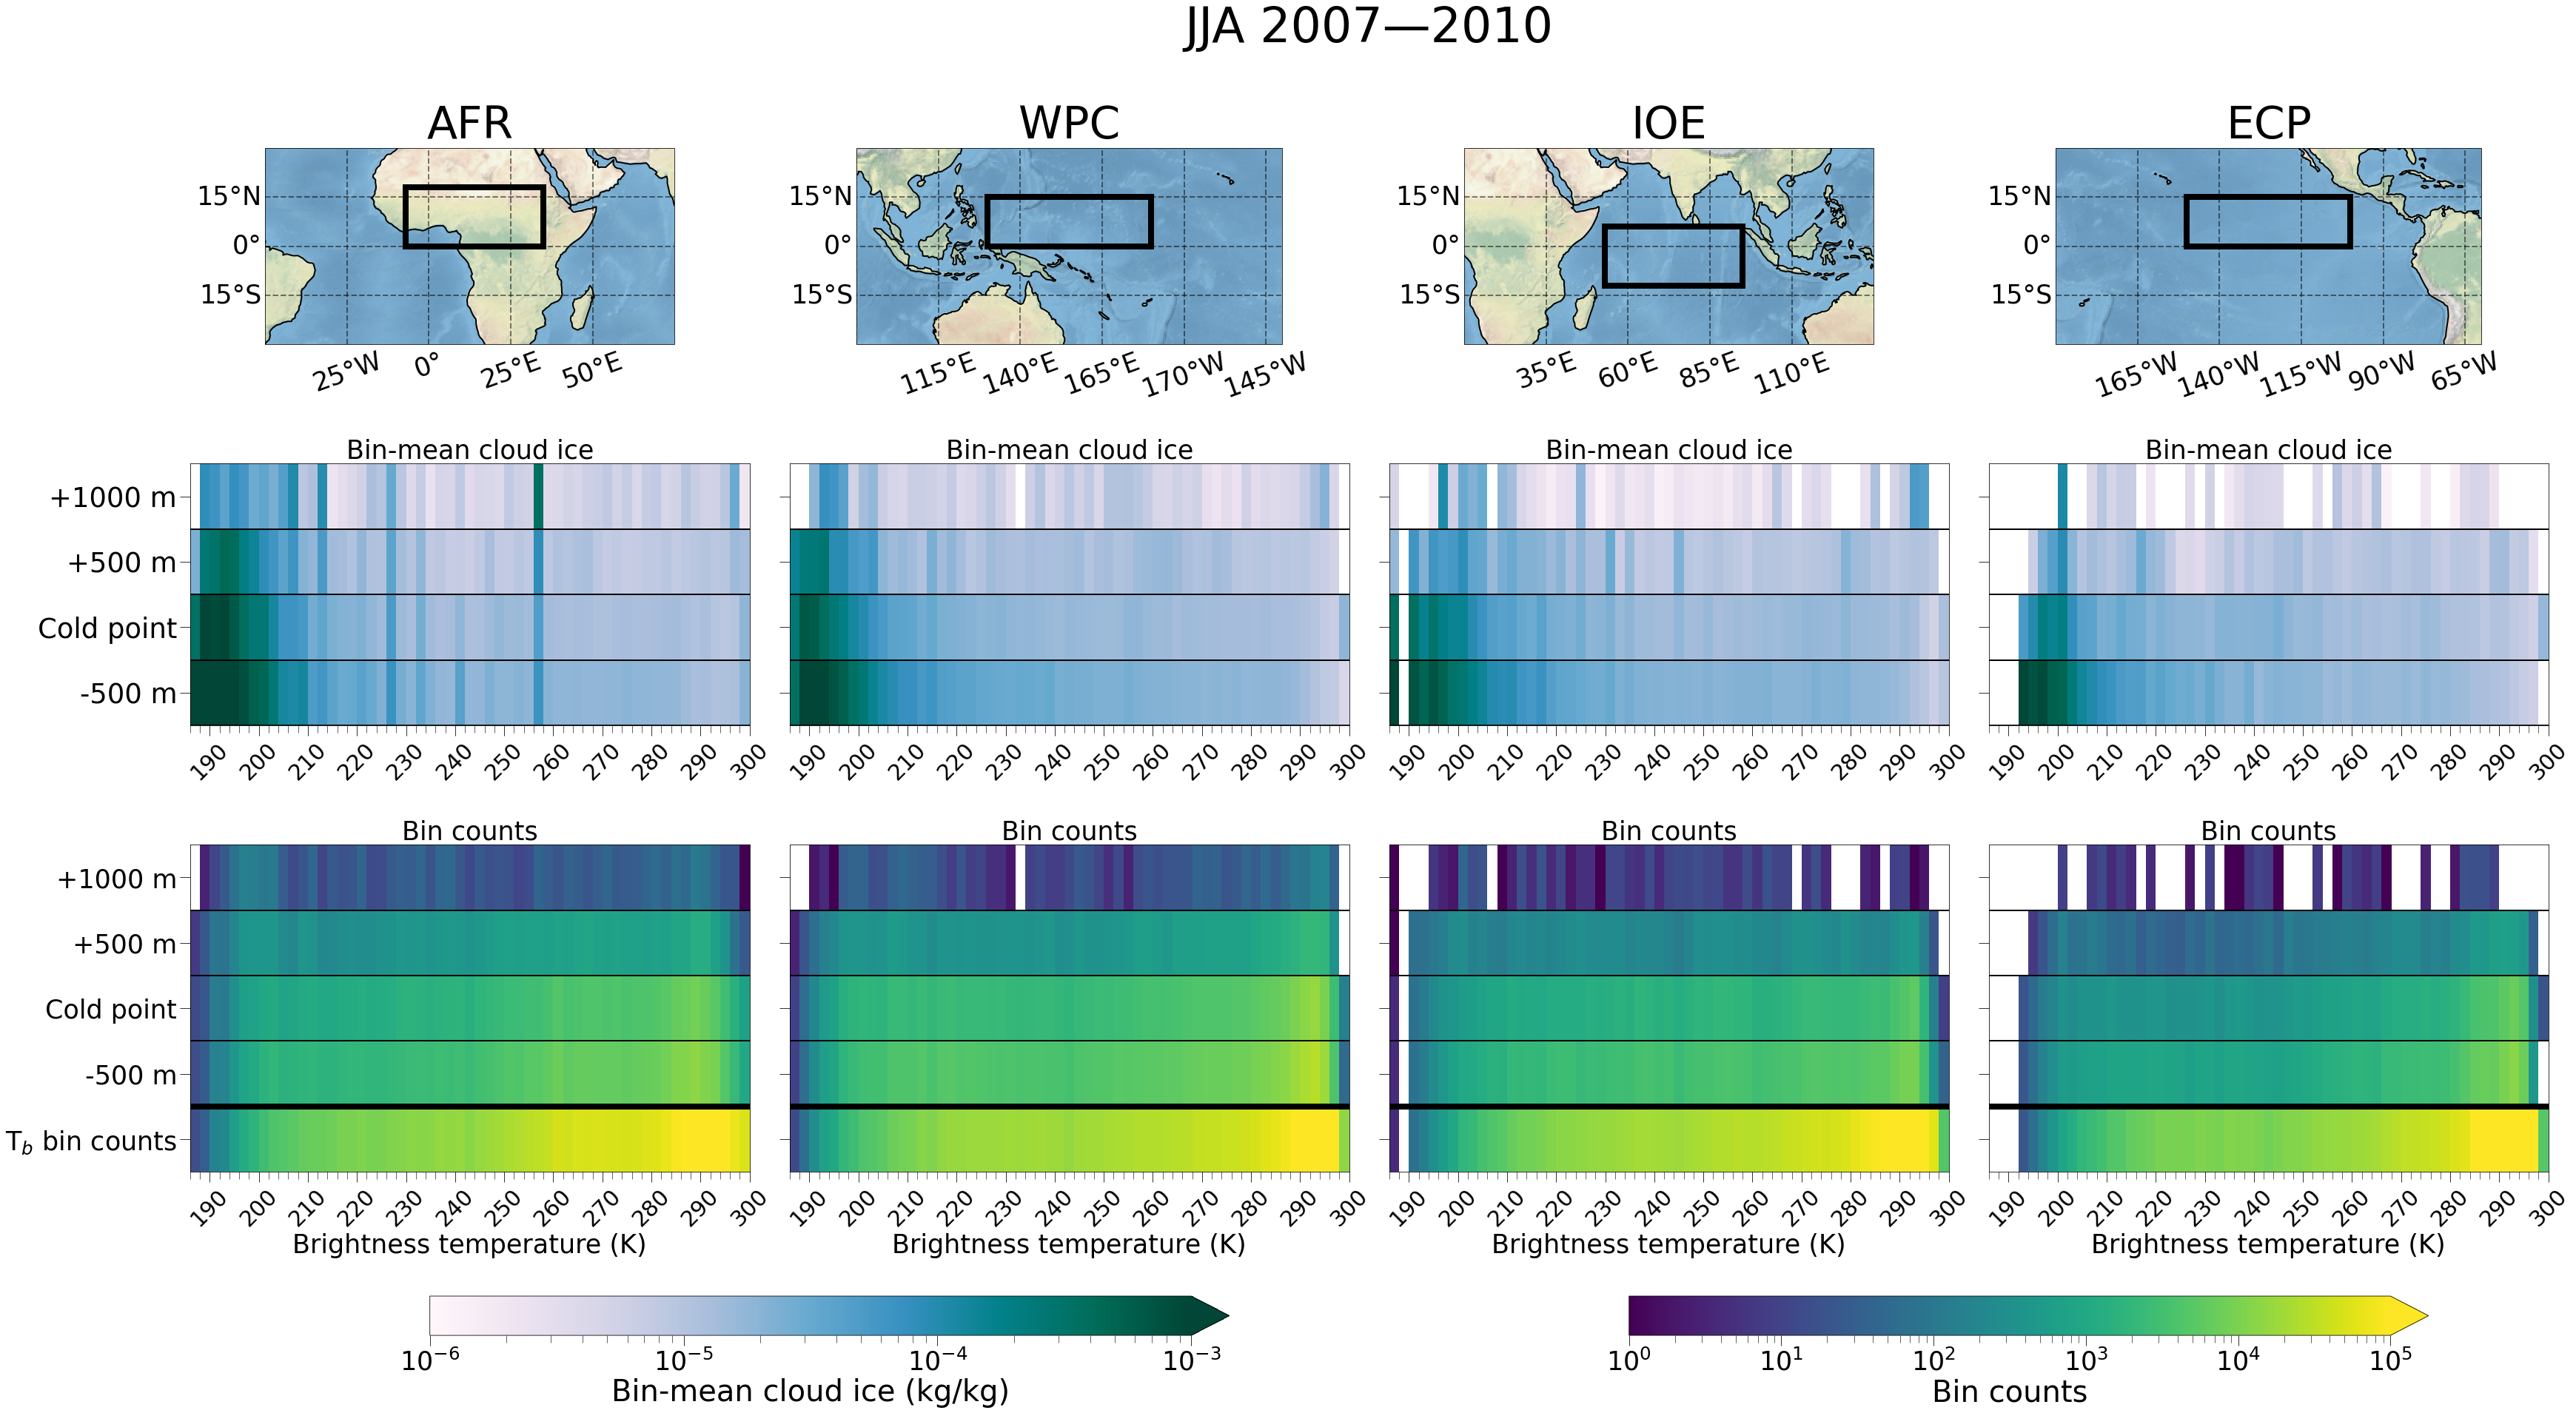

In [22]:
# JJA
bin_qi_season(qi_means_dict_jja, qi_counts_dict_jja, region_tb_counts_dict_jja, "JJA", years_str, tb_bins, mean_lims=qi_lims,
                   fsize=fsize, tsize=tsize, labsize=30, figsize=figsize, tb_count_lims=count_lims,
                   count_cmap=count_cmap, mean_cmap=mean_cmap, save=save_plots, save_dir=plot_save_dir)


### Just radar+lidar

DARDAR_qi_binned_by_Tb_with_counts_and_map_both_instr_2007-2010.png


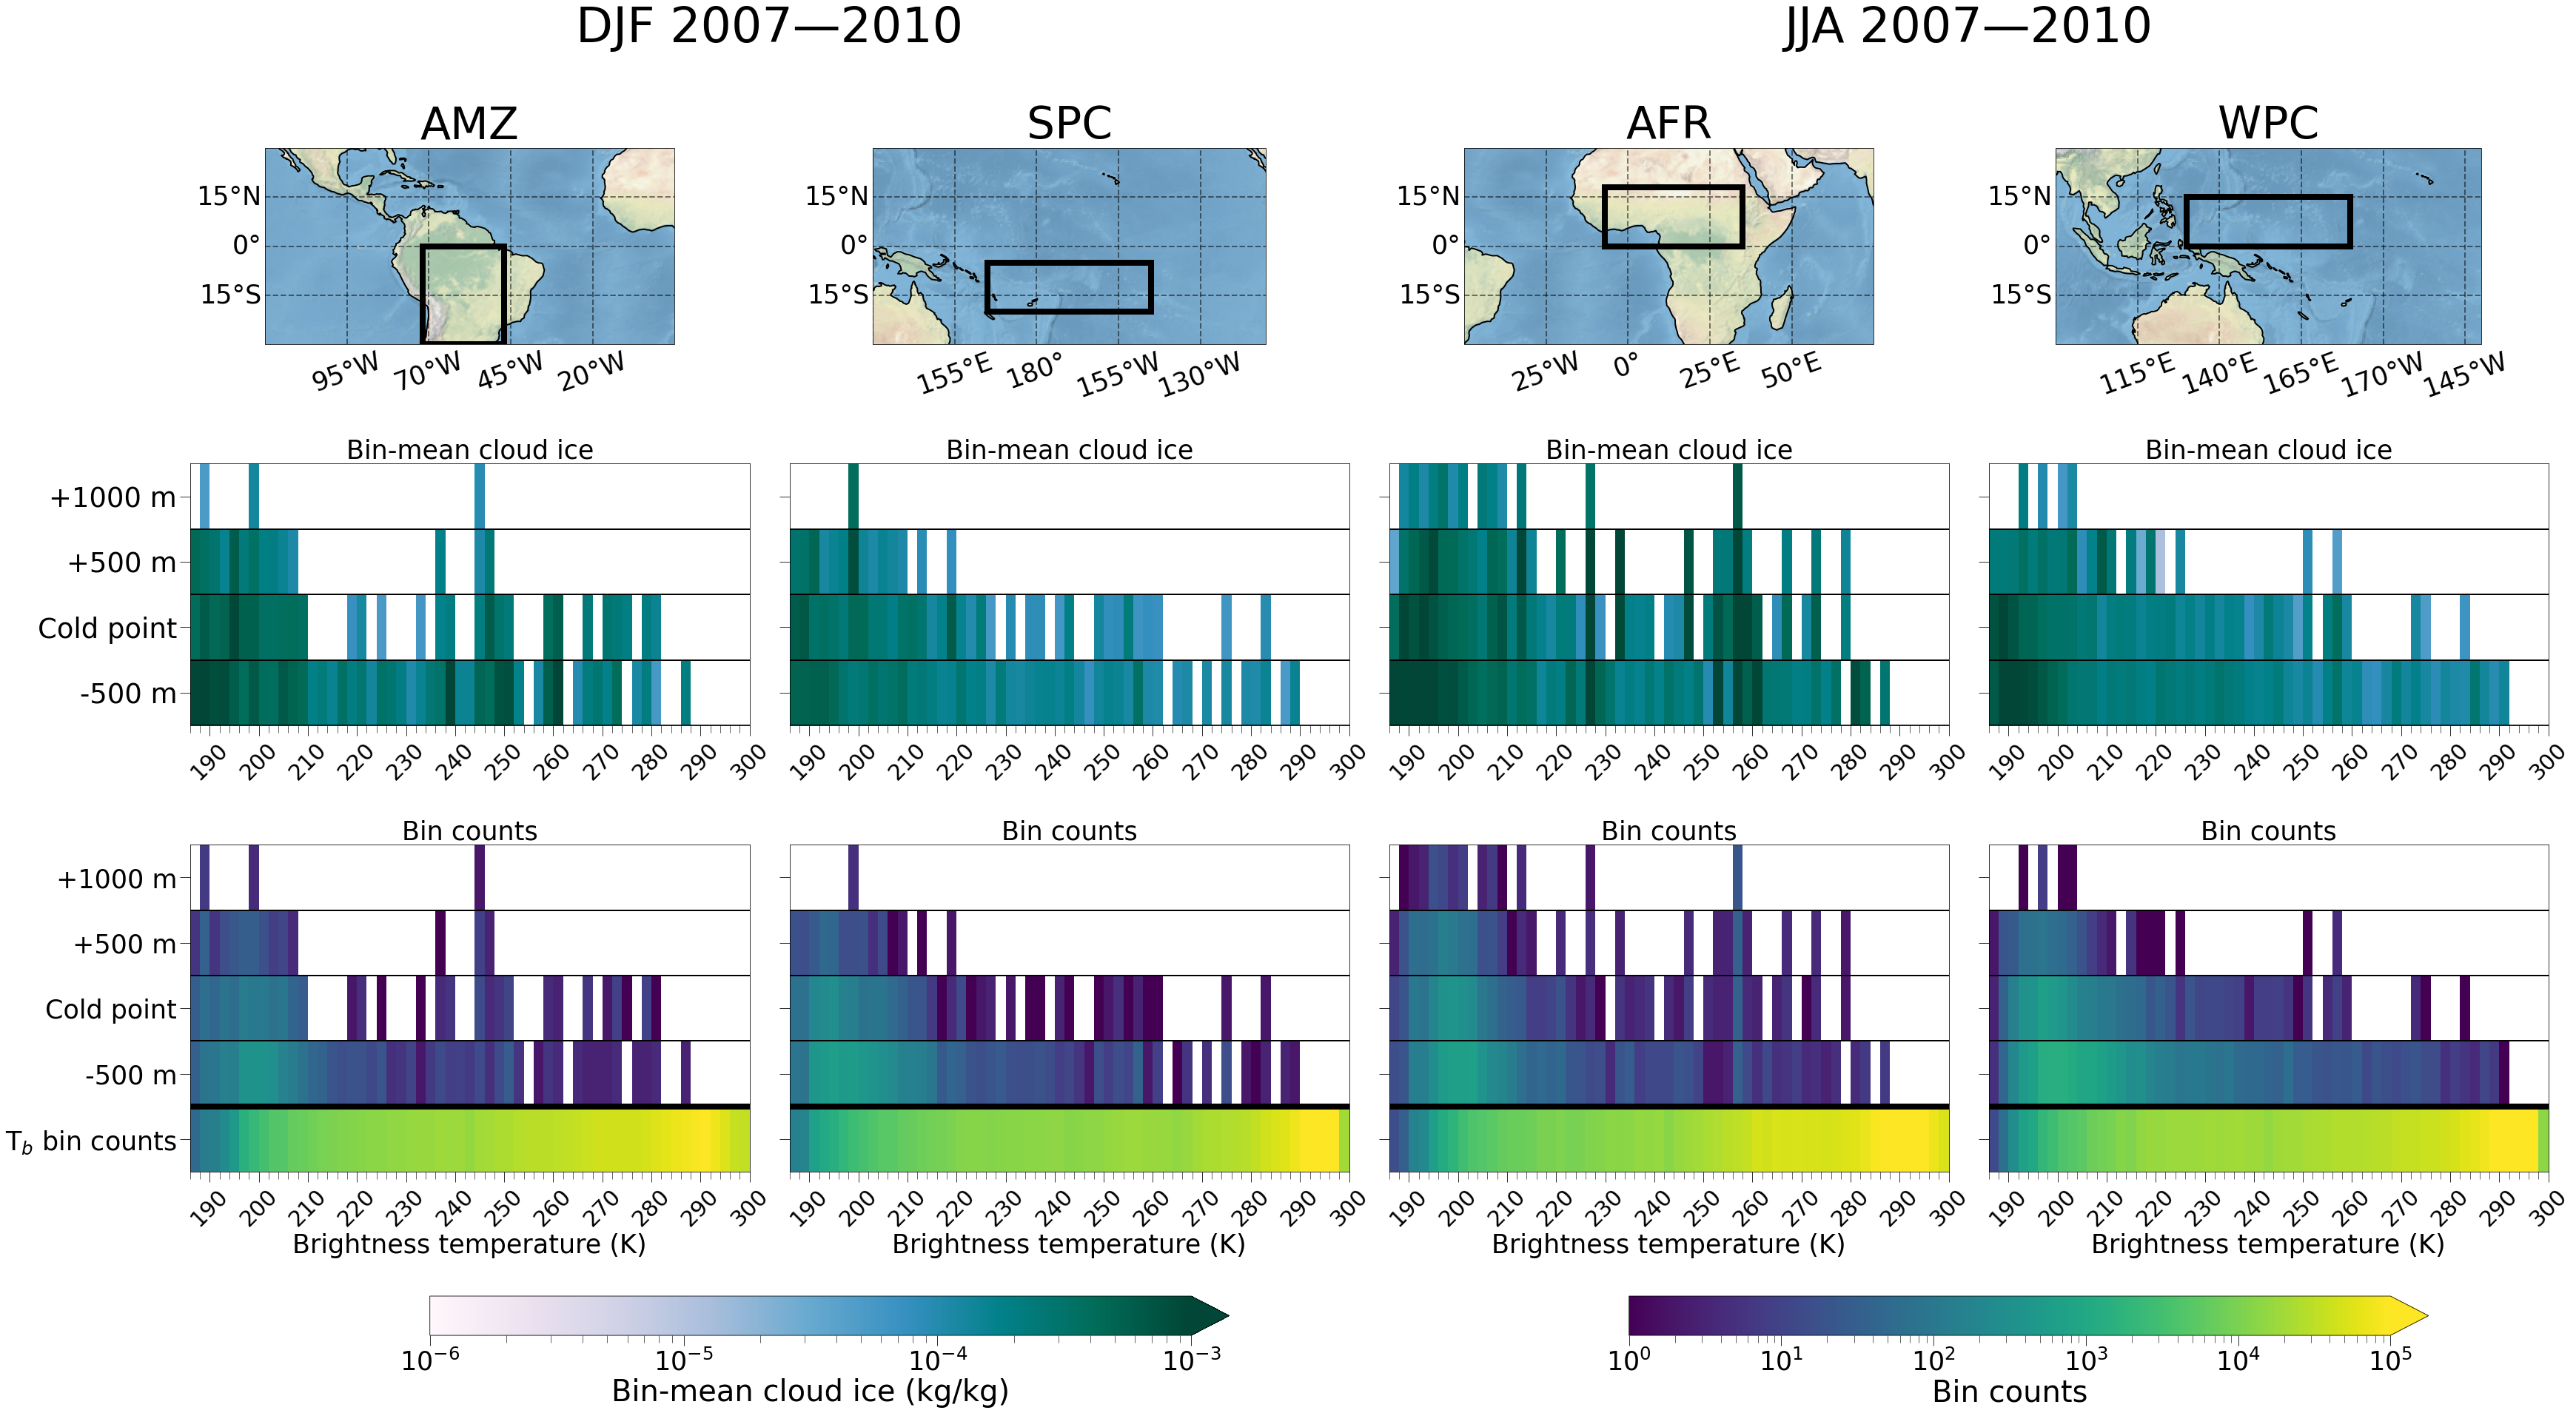

DARDAR_qi_binned_by_Tb_with_counts_both_instr_2007-2010.png


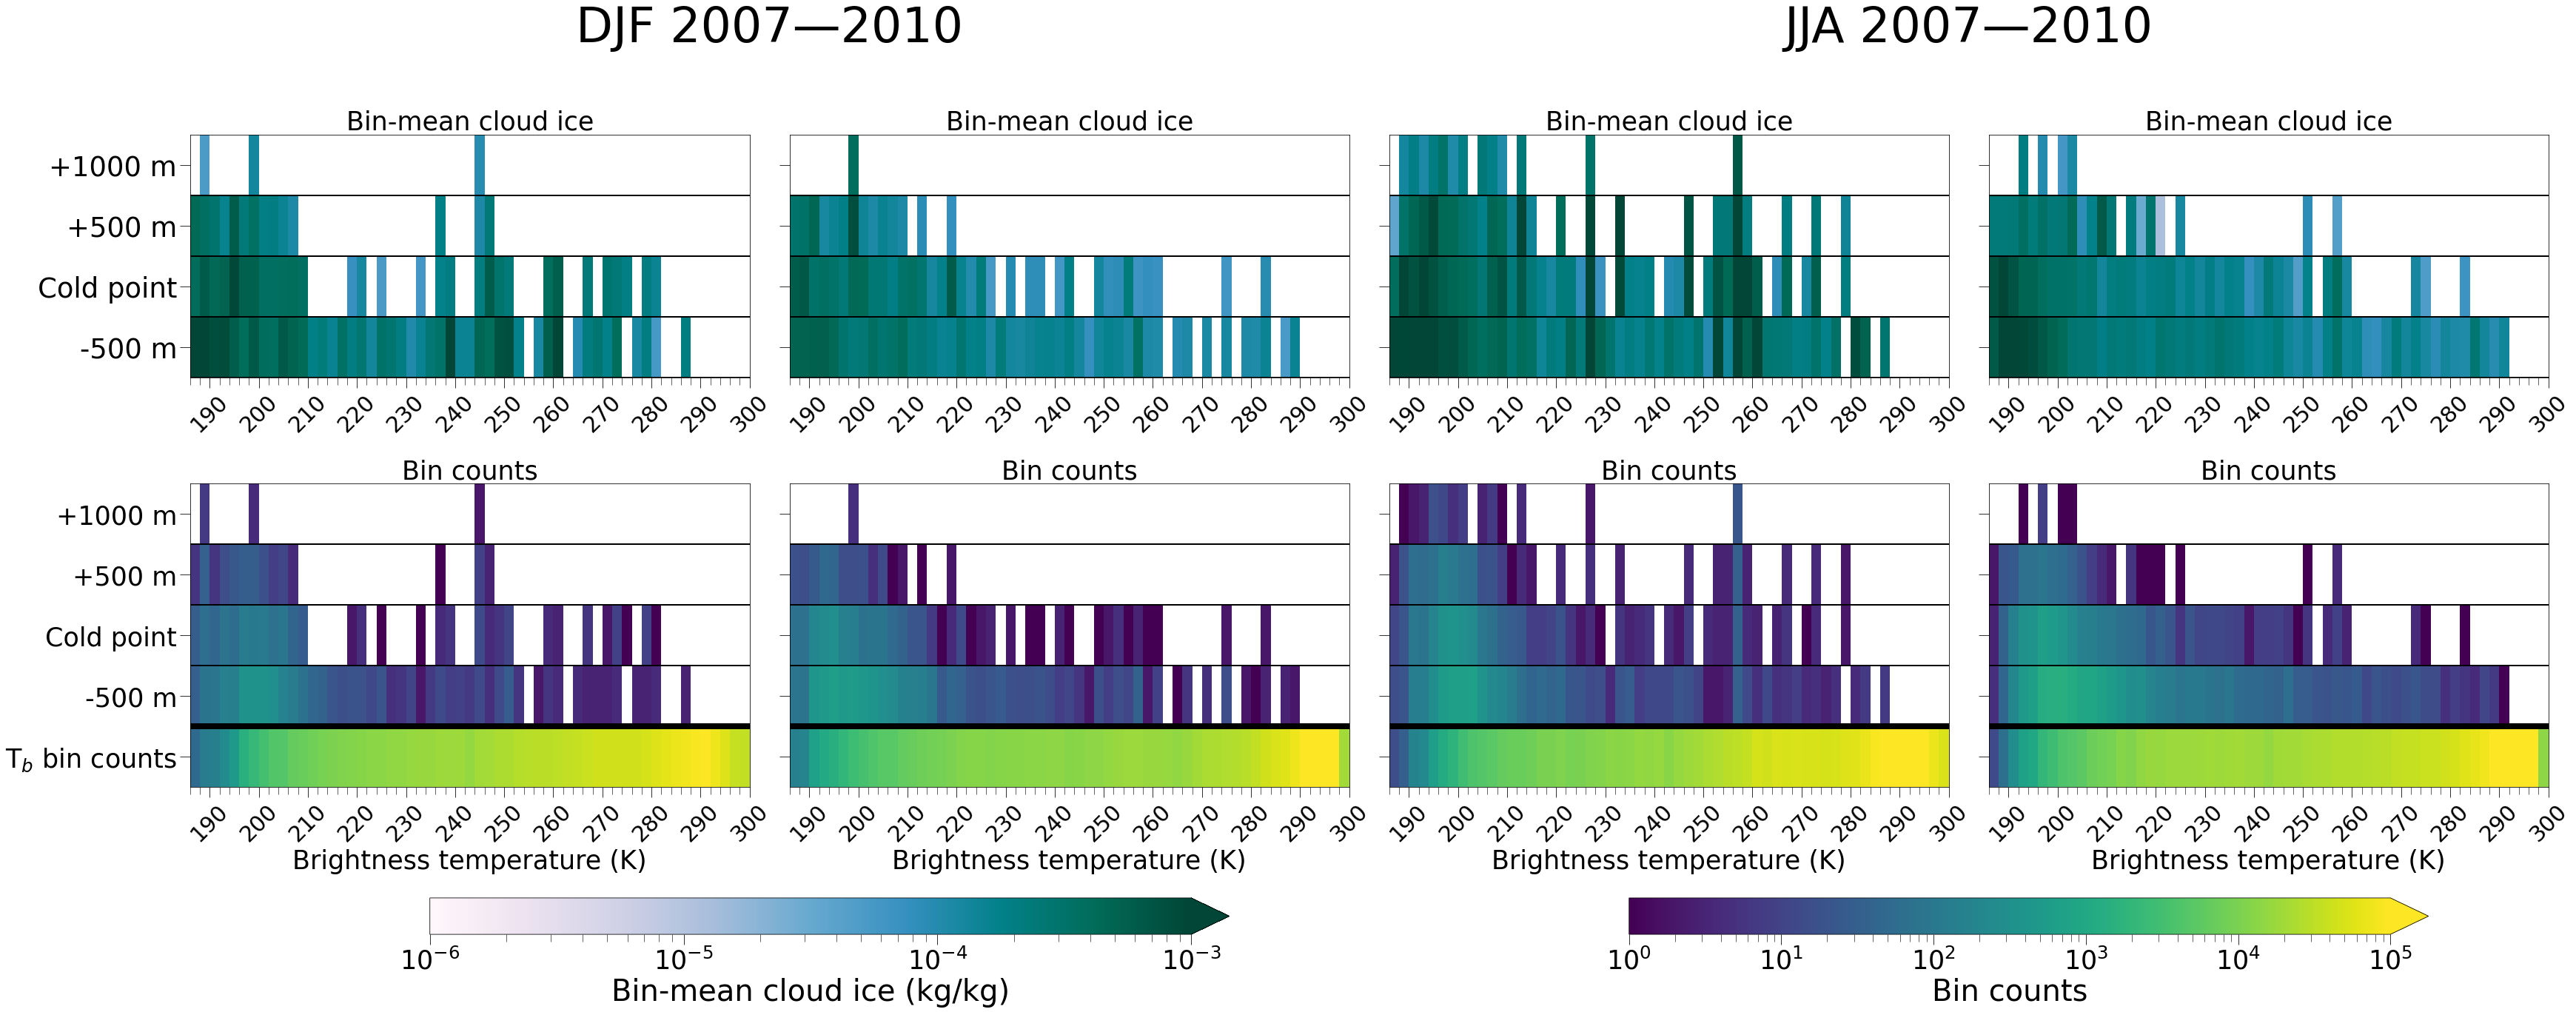

In [23]:
# main text

qi3_means_dict_main = {
    "AMZ": qi3_means_dict_djf["AMZ"],
    "SPC": qi3_means_dict_djf["SPC"],
    "AFR": qi3_means_dict_jja["AFR"],
    "WPC": qi3_means_dict_jja["WPC"],
}
qi3_counts_dict_main = {
    "AMZ": qi3_counts_dict_djf["AMZ"],
    "SPC": qi3_counts_dict_djf["SPC"],
    "AFR": qi3_counts_dict_jja["AFR"],
    "WPC": qi3_counts_dict_jja["WPC"],
}
region_tb_counts_dict_main = {
    "AMZ": region_tb_counts_dict_djf["AMZ"],
    "SPC": region_tb_counts_dict_djf["SPC"],
    "AFR": region_tb_counts_dict_jja["AFR"],
    "WPC": region_tb_counts_dict_jja["WPC"],
}

bin_qi_season(qi3_means_dict_main, qi3_counts_dict_main, region_tb_counts_dict_main, ["DJF", "JJA"], years_str, tb_bins, mean_lims=qi_lims,
               fsize=fsize, tsize=tsize, labsize=30, figsize=figsize, tb_count_lims=count_lims,
               count_cmap=count_cmap, mean_cmap=mean_cmap, save=save_plots, save_dir=plot_save_dir,
              show_maps=True, si=False)

bin_qi_season(qi3_means_dict_main, qi3_counts_dict_main, region_tb_counts_dict_main, ["DJF", "JJA"], years_str, tb_bins, mean_lims=qi_lims,
               fsize=fsize, tsize=tsize, labsize=30, figsize=(60, 23), tb_count_lims=count_lims,
               count_cmap=count_cmap, mean_cmap=mean_cmap, save=save_plots, save_dir=plot_save_dir, 
              show_maps=False, si=False)


DARDAR_qi_binned_by_Tb_with_counts_and_map_both_instr_2007-2010_si.png


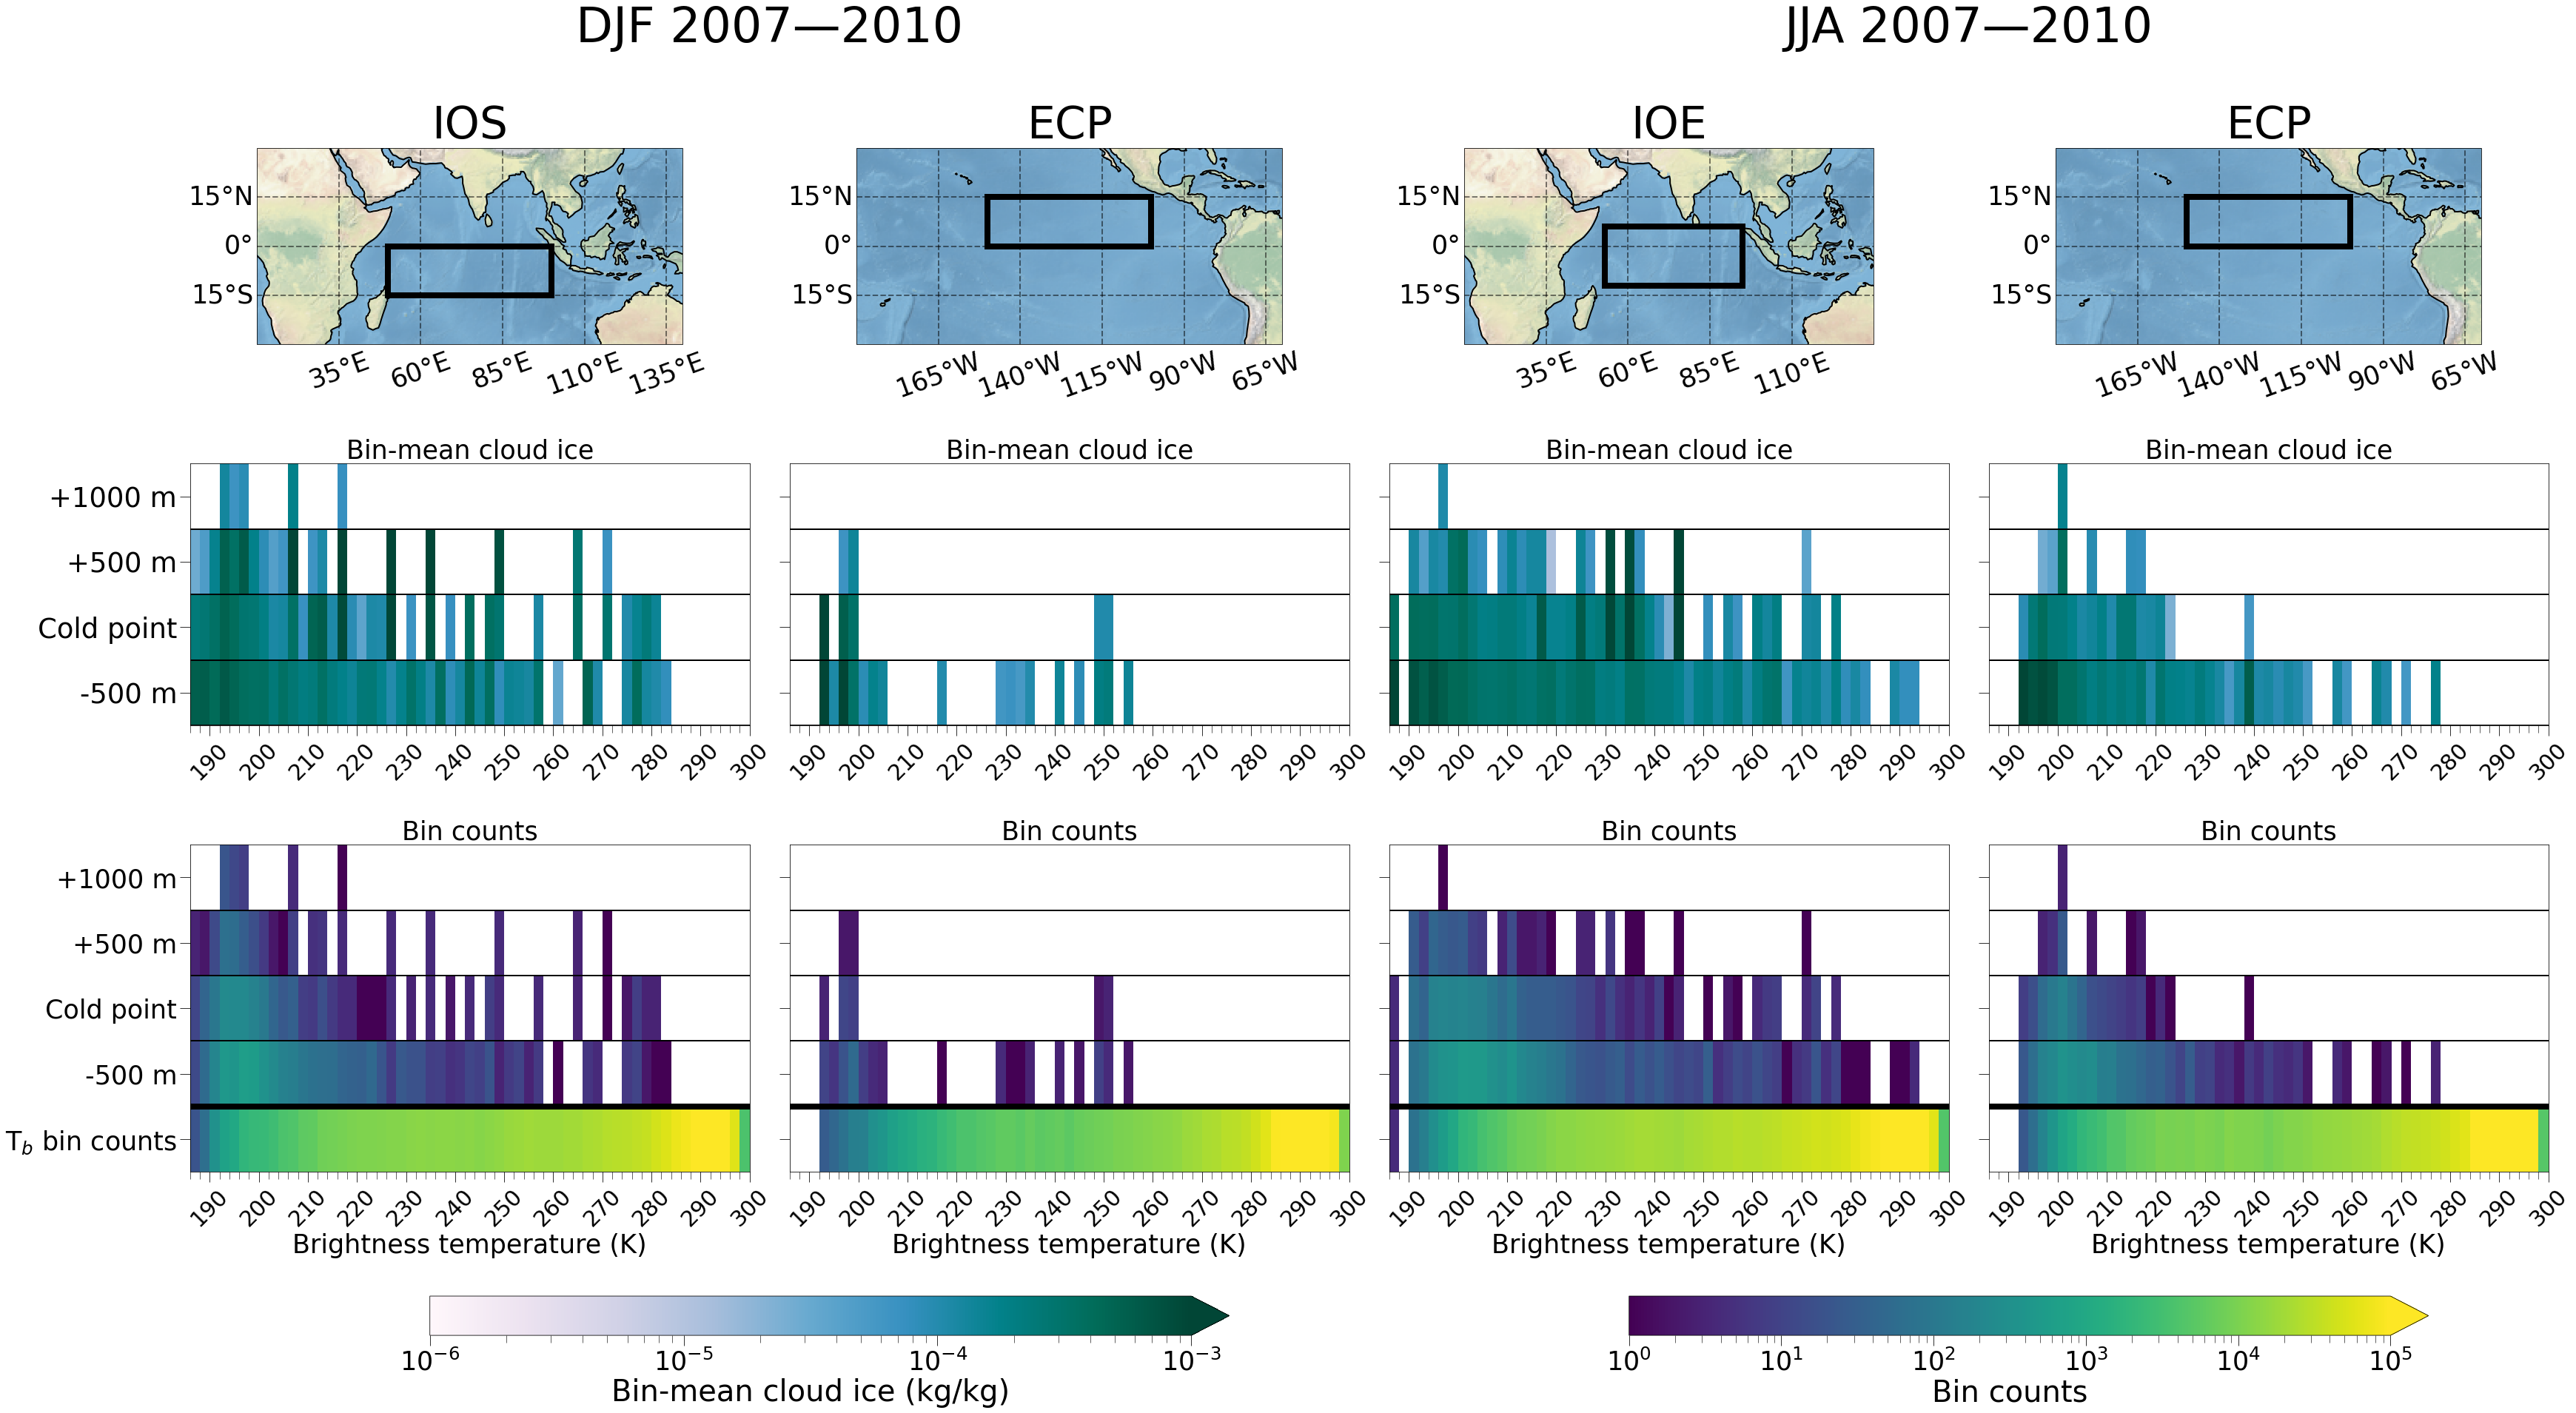

DARDAR_qi_binned_by_Tb_with_counts_both_instr_2007-2010_si.png


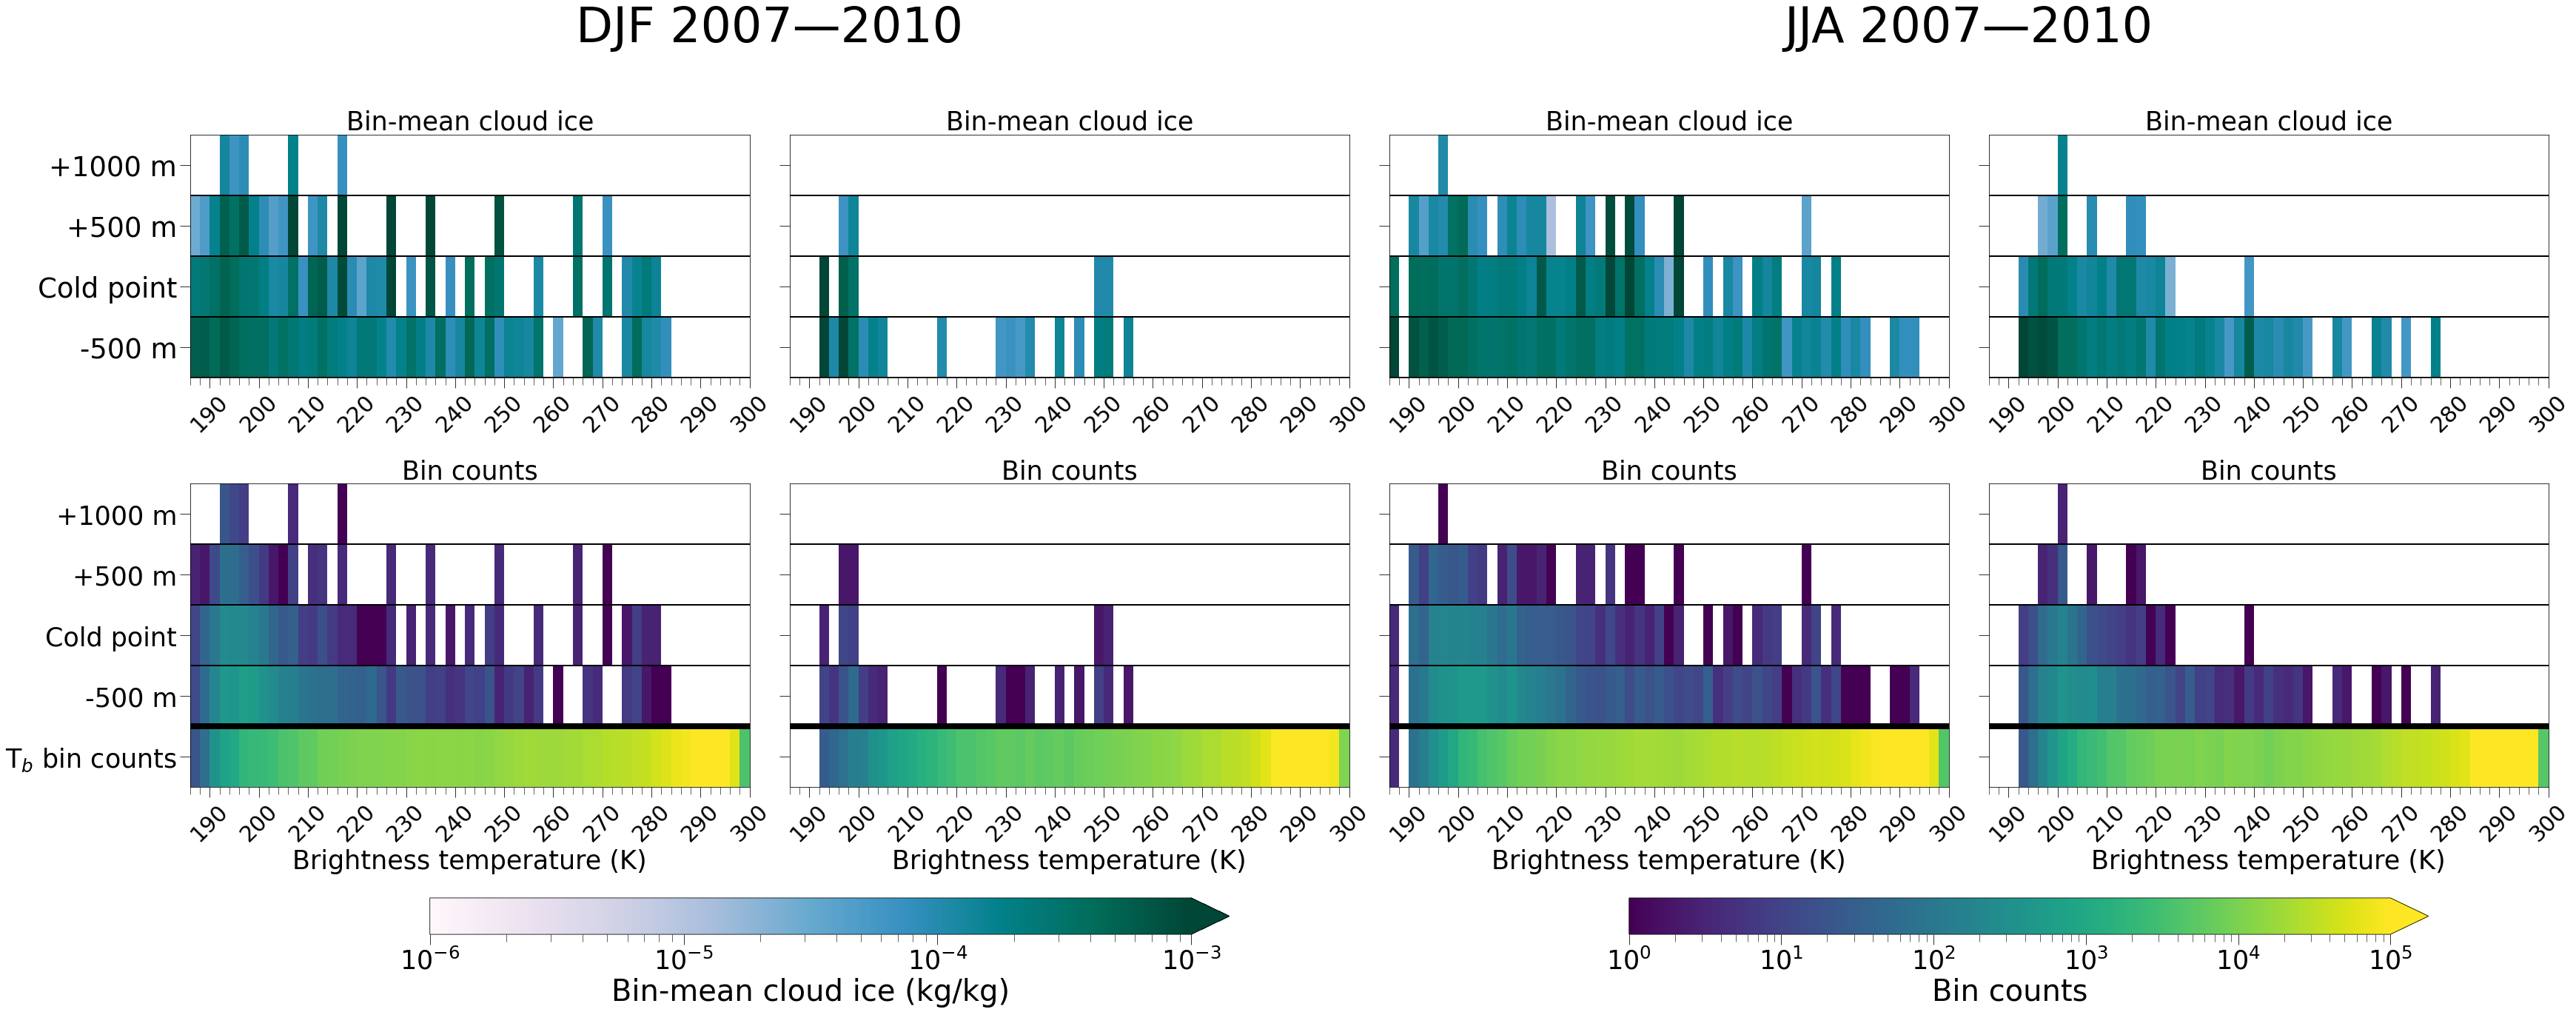

In [28]:
# supporting info

qi3_means_dict_si = {
    "IOS": qi3_means_dict_djf["IOS"],
    "ECP": qi3_means_dict_djf["ECP"],
    "IOE": qi3_means_dict_jja["IOE"],
    "ECP2": qi3_means_dict_jja["ECP"],
}
qi3_counts_dict_si = {
    "IOS": qi3_counts_dict_djf["IOS"],
    "ECP": qi3_counts_dict_djf["ECP"],
    "IOE": qi3_counts_dict_jja["IOE"],
    "ECP2": qi3_counts_dict_jja["ECP"],
}
region_tb_counts_dict_si = {
    "IOS": region_tb_counts_dict_djf["IOS"],
    "ECP": region_tb_counts_dict_djf["ECP"],
    "IOE": region_tb_counts_dict_jja["IOE"],
    "ECP2": region_tb_counts_dict_jja["ECP"],
}

bin_qi_season(qi3_means_dict_si, qi3_counts_dict_si, region_tb_counts_dict_si, ["DJF", "JJA"], years_str, tb_bins, mean_lims=qi_lims,
               fsize=fsize, tsize=tsize, labsize=30, figsize=figsize, tb_count_lims=count_lims,
               count_cmap=count_cmap, mean_cmap=mean_cmap, save=save_plots, save_dir=plot_save_dir,
              show_maps=True, si=True)

bin_qi_season(qi3_means_dict_si, qi3_counts_dict_si, region_tb_counts_dict_si, ["DJF", "JJA"], years_str, tb_bins, mean_lims=qi_lims,
               fsize=fsize, tsize=tsize, labsize=30, figsize=(60, 23), tb_count_lims=count_lims,
               count_cmap=count_cmap, mean_cmap=mean_cmap, save=save_plots, save_dir=plot_save_dir, 
              show_maps=False, si=True)
